In [1]:
import numpy as np
import pandas as pd
import re
import string
from string import digits
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical  # Updated import
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/kindle_review.csv"
df = pd.read_csv(path)

In [4]:
df.shape

(12000, 4)

In [5]:
df.head()

,Unnamed: 0,rating,reviewText,summary
0,0,5,This book was the very first bookmobile book I...,50 + years ago...
1,1,1,"When I read the description for this book, I c...",Boring! Boring! Boring!
2,2,5,I just had to edit this review. This book is a...,Wiggleliscious/new toy ready/!!
3,3,5,I don't normally buy 'mystery' novels because ...,Very good read.
4,4,5,"This isn't the kind of book I normally read, a...",Great Story!


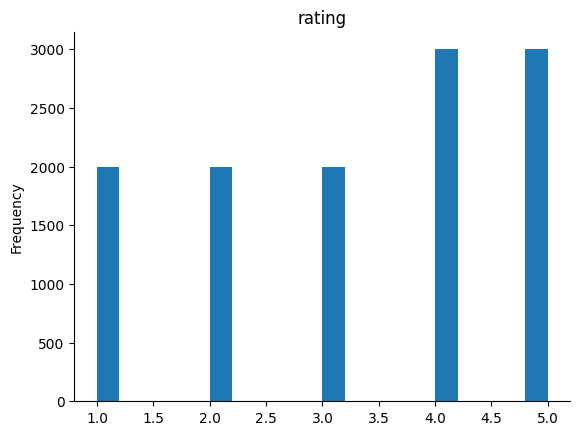

In [6]:
# @title rating

from matplotlib import pyplot as plt
df['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
df["rating"]=df["rating"].map({1:"negative", 2:"negative", 3:"neutral", 4:"positive", 5:"positive"})
df["rating"].value_counts()

rating
positive    6000
negative    4000
neutral     2000
Name: count, dtype: int64

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [9]:
df.rating.value_counts()

rating
positive    6000
negative    4000
neutral     2000
Name: count, dtype: int64

In [10]:
# Convert source and target text to lowercase
df['reviewText'] = df['reviewText'].str.lower()
# df['summary'] = df['summary'].str.lower()

# Remove quotes from source and target text
df['reviewText'] = df['reviewText'].str.replace("'", '')
# df['summary'] = df['summary'].str.replace("'", '')

# Create a set of all special characters
special_characters = set(string.punctuation)

# Remove all the special characters
df['reviewText'] = df['reviewText'].apply(lambda x: ''.join(char for char in str(x) if char not in special_characters))
# df['summary'] = df['summary'].apply(lambda x: ''.join(char for char in str(x) if char not in special_characters))

# Remove digits from source and target sentences
num_digits = str.maketrans('', '', digits)
df['reviewText'] = df['reviewText'].apply(lambda x: x.translate(num_digits) if isinstance(x, str) else x)
# df['summary'] = df['summary'].apply(lambda x: x.translate(num_digits) if isinstance(x, str) else x)

# Remove extra spaces
df['reviewText'] = df['reviewText'].apply(lambda x: x.strip() if isinstance(x, str) else x)
# df['summary'] = df['summary'].apply(lambda x: x.strip() if isinstance(x, str) else x)
df['reviewText'] = df['reviewText'].apply(lambda x: re.sub(" +", " ", x) if isinstance(x, str) else x)
# df['summary'] = df['summary'].apply(lambda x: re.sub(" +", " ", x) if isinstance(x, str) else x)

# Print the preprocessed DataFrame
print(df.head())


   Unnamed: 0    rating                                         reviewText  \
0           0  positive  this book was the very first bookmobile book i...   
1           1  negative  when i read the description for this book i co...   
2           2  positive  i just had to edit this review this book is an...   
3           3  positive  i dont normally buy mystery novels because i j...   
4           4  positive  this isnt the kind of book i normally read alt...   

                           summary  
0                50 + years ago...  
1          Boring! Boring! Boring!  
2  Wiggleliscious/new toy ready/!!  
3                  Very good read.  
4                     Great Story!  


In [11]:
# Initialize lists to store sentence lengths
reviewText_length_list = []

# Iterate over each reviewText and calculate its length
for text in df['reviewText']:
    reviewText_length_list.append(len(text.split(' ')))

# Find the maximum sentence length
max_reviewText_length = max(reviewText_length_list)

# Print the maximum sentence length
print("Max length of the reviewText sentence:", max_reviewText_length)


Max length of the reviewText sentence: 2138


In [12]:
df.isnull().count()

Unnamed: 0    12000
rating        12000
reviewText    12000
summary       12000
dtype: int64

In [13]:
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    return tokens


In [14]:
# Remove stopwords and apply lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [15]:
df.head()

,Unnamed: 0,rating,reviewText,summary
0,0,positive,this book was the very first bookmobile book i...,50 + years ago...
1,1,negative,when i read the description for this book i co...,Boring! Boring! Boring!
2,2,positive,i just had to edit this review this book is an...,Wiggleliscious/new toy ready/!!
3,3,positive,i dont normally buy mystery novels because i j...,Very good read.
4,4,positive,this isnt the kind of book i normally read alt...,Great Story!


In [16]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Label encode the sentiments
label_encoder = LabelEncoder()
encoded_sentiments = label_encoder.fit_transform(df['rating'])

# Convert the encoded sentiments to one-hot encoding
one_hot_sentiments = to_categorical(encoded_sentiments, num_classes=3)

print(one_hot_sentiments)


[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [17]:
def preprocess_tokens(tokens):
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return filtered_tokens

# Apply preprocessing to your DataFrame
df['reviewText'] = df['reviewText'].apply(preprocess_text)
df['reviewText'] = df['reviewText'].apply(preprocess_tokens)

In [18]:
df['reviewText'][0]

['book',
 'first',
 'bookmobile',
 'book',
 'bought',
 'school',
 'book',
 'club',
 'loved',
 'story',
 'bet',
 'dollar',
 'donut',
 'love',
 'memory',
 'serf',
 'bought',
 'book',
 'th',
 'grade',
 'would',
 'looking',
 'forward',
 'reliving',
 'memory']

In [19]:
n_most_common_words = 8000
max_len = 500
tokenizer = Tokenizer(num_words=n_most_common_words)
tokenizer.fit_on_texts(df['reviewText'].values)
sequences = tokenizer.texts_to_sequences(df['reviewText'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 41117 unique tokens.


In [20]:
epochs = 10
emb_dim = 100
batch_size = 32
df[:5]

,Unnamed: 0,rating,reviewText,summary
0,0,positive,"[book, first, bookmobile, book, bought, school...",50 + years ago...
1,1,negative,"[read, description, book, couldnt, wait, read,...",Boring! Boring! Boring!
2,2,positive,"[edit, review, book, believe, got, right, upda...",Wiggleliscious/new toy ready/!!
3,3,positive,"[dont, normally, buy, mystery, novel, dont, li...",Very good read.
4,4,positive,"[isnt, kind, book, normally, read, although, t...",Great Story!


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, one_hot_sentiments, test_size=0.2, random_state=42, stratify=one_hot_sentiments)
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))


((9600, 500), (9600, 3), (2400, 500), (2400, 3))


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.layers import BatchNormalization

# Define model parameters
n_most_common_words = 8000
max_len = 500
emb_dim = 100
epochs = 10
batch_size = 32

from keras.layers import GlobalMaxPooling1D

# Define the model
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=max_len))
model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))  # Reduced number of units
model.add(GlobalMaxPooling1D())  # Global max pooling instead of another LSTM layer
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))  # Increased dropout rate
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])



# Evaluate the model
accr = model.evaluate(X_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0], accr[1]))


Epoch 1/10
240/240 [==============================] - 169s 692ms/step - loss: 1.1748 - accuracy: 0.4961 - val_loss: 1.0581 - val_accuracy: 0.4969
Epoch 2/10
240/240 [==============================] - 168s 699ms/step - loss: 0.9497 - accuracy: 0.5783 - val_loss: 0.7764 - val_accuracy: 0.6979
Epoch 3/10
240/240 [==============================] - 168s 700ms/step - loss: 0.7123 - accuracy: 0.7109 - val_loss: 0.7295 - val_accuracy: 0.7151
Epoch 4/10
240/240 [==============================] - 163s 680ms/step - loss: 0.6129 - accuracy: 0.7609 - val_loss: 0.7326 - val_accuracy: 0.7078
Epoch 5/10
240/240 [==============================] - 165s 688ms/step - loss: 0.5508 - accuracy: 0.7932 - val_loss: 0.7706 - val_accuracy: 0.7052
Epoch 6/10
240/240 [==============================] - 166s 692ms/step - loss: 0.4933 - accuracy: 0.8118 - val_loss: 0.8254 - val_accuracy: 0.7057
Epoch 7/10
240/240 [==============================] - 170s 709ms/step - loss: 0.4598 - accuracy: 0.8315 - val_loss: 0.8738 -

In [23]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

75/75 [==============================] - 6s 86ms/step - loss: 0.9660 - accuracy: 0.6917
Test set
  Loss: 0.966
  Accuracy: 0.692


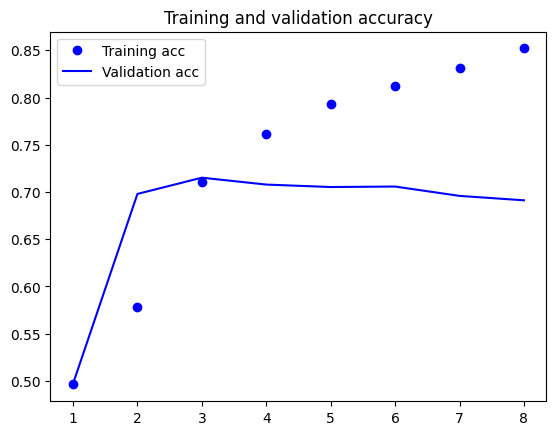

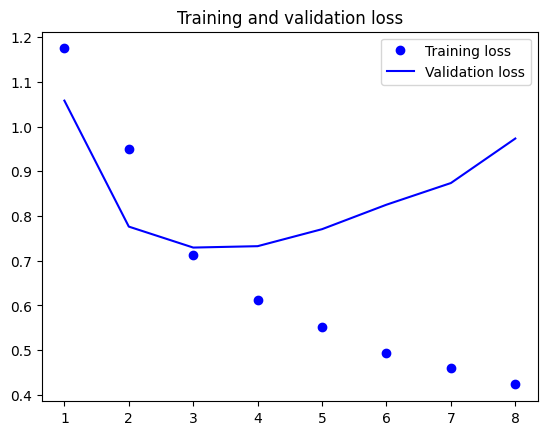

In [24]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

75/75 [==============================] - 12s 155ms/step


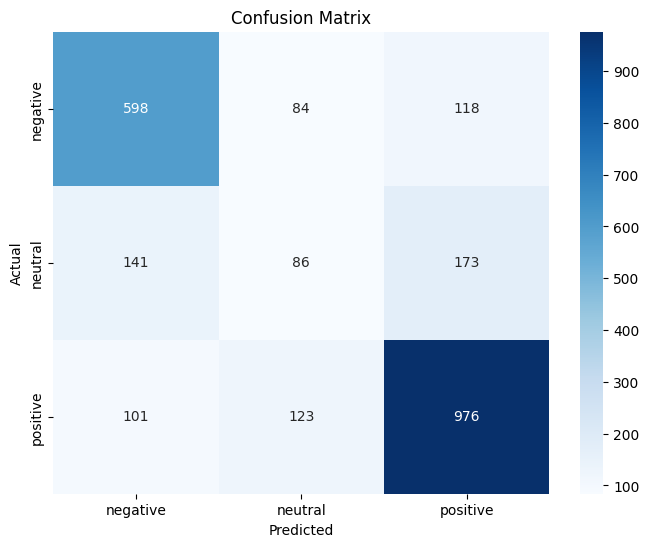

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Predict probabilities for test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Generate confusion matrix
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
